# Honolulu Weather Analysis

In [2]:
%matplotlib inline

# Import plot styles
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib.dates import MonthLocator, DateFormatter
import calendar


# Import dependencies
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect, func

### Reflect Tables into SQLAlchemy ORM

In [3]:
# Create database connection
database_path = Path("../Resources/hawaii.sqlite")
engine = create_engine(f"sqlite:///{database_path}")

# Delare a Base using automap_base
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

In [4]:
# Diplay all mapped classes
Base.classes.keys()

['measurement', 'station']

In [5]:
# Assign classes to variables
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

In [7]:
# Inspect the tables
inspector = inspect(engine)

# Display station columns
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

# Display measurement columns
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Precipitation Analysis

In [8]:
# Query to find the most recent date
most_recent_date = session.query(func.max(measurement.date)).scalar()

print(f"The most recent date: {most_recent_date}")

The most recent date: 2017-08-23


In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
most_recent_datetime = dt.datetime.strptime(most_recent_date,"%Y-%m-%d").date()


# Calculate the date one year from the last date in data set.
query_date = most_recent_datetime - dt.timedelta(days=365)
print(f"Query Date: {query_date}")


Query Date: 2016-08-23


In [10]:
# Perform a query to retrieve the date and precipitation
last_year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()

# Save the query results to a dataframe
last_year_prcp_df = pd.DataFrame(last_year_prcp, columns = ["Date", "Precipitation"])

# Sort by date
sorted_prcp_df = last_year_prcp_df.sort_values(by = "Date")

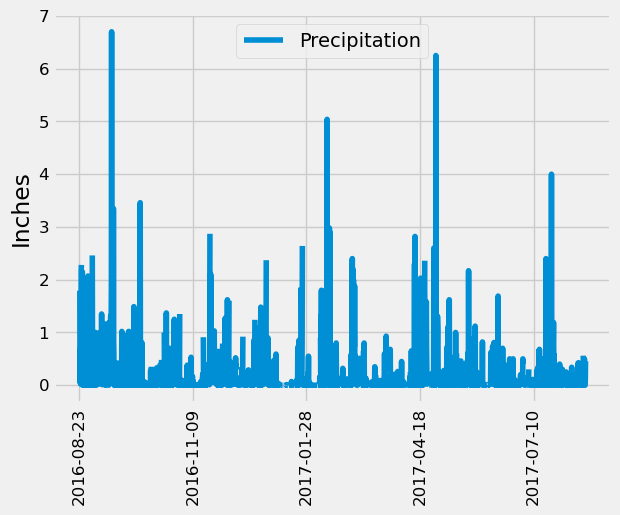

In [11]:
sorted_prcp_df.plot(kind='line',x='Date', xlabel='',ylabel='Inches',legend=True, fontsize = 12)
plt.xticks(rotation=90)
plt.show()

This is daily precipitation data from several weather stations around Honolulu. To make the data more meaningful, we will drop null values and get a daily average precipitation in inches. This will allow us to check for variability in precipitation across the most recent year of data. 

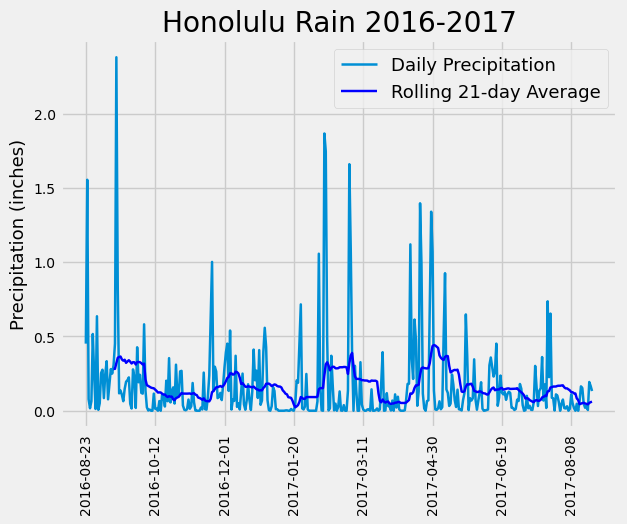

In [12]:
# Drop null rows
clean_prcp = sorted_prcp_df.dropna()

# Convert "Date" column to datetime format
pd.to_datetime(clean_prcp["Date"])

# Aggregate "Precipitation" to get daily average
daily_avg_prcp = clean_prcp.groupby("Date").agg({"Precipitation": "mean"})

# Calculate rolling 21-day average
rolling_avg = daily_avg_prcp['Precipitation'].rolling(21).mean()

# Plot daily average
daily_avg_prcp.plot(linewidth = 1.8, title = "Honolulu Rain 2016-2017")
# Plot the rolling sum on the same plot
rolling_avg.plot(color='blue', linewidth = 1.75)
# Format the plot 
plt.ylabel("Precipitation (inches)", fontsize = 13)
plt.xlabel("")
plt.yticks(fontsize = 10)
plt.xticks(rotation = 90, fontsize = 10)
plt.legend(['Daily Precipitation','Rolling 21-day Average'], fontsize = 13)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcp_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(measurement.station).group_by(measurement.station).count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

descending_stations = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()

for station, count in descending_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [16]:
# Grab the most active station ID
most_active_station = descending_stations[0][0]

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Observed Temperature, August 2016- August 2017')

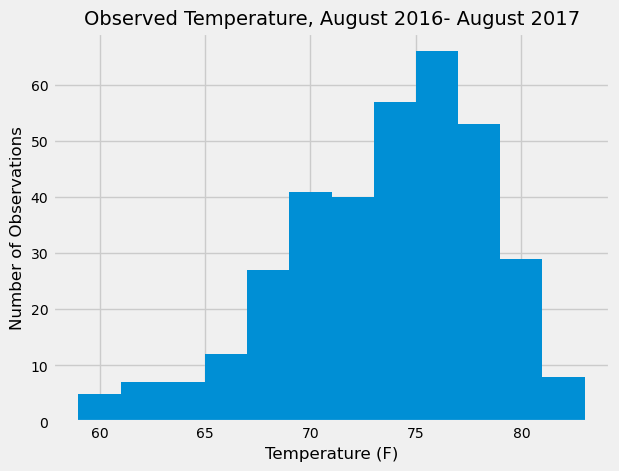

In [17]:
# Query the last 12 months of temperature observation data for the most active station
station_recent = session.query(measurement.tobs, measurement.date).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= query_date)

# Convert to dataframe
station_recent_df = pd.DataFrame(station_recent, columns = ["Temperature", "Date"])
# Plot as histogram
ax = station_recent_df.plot.hist(bins = 12, legend = False)
# Format table
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel("Temperature (F)", fontsize = 12)
ax.set_ylabel("Number of Observations", fontsize = 12)
ax.set_title("Observed Temperature, August 2016- August 2017", fontsize = 14)

In [18]:
# Close the session
session.close()